# Libraries

In [119]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.rdmolfiles import MolFragmentToSmiles
IPythonConsole.molSize = (600,300)
IPythonConsole.drawOptions.addAtomIndices = True

# Defining the functions

In [120]:
def get_biggest_ringsys(mol, includeSpiro=False):

    """
    Returns the atom indexes of the largest ring system present in a structure

    Parameters:
    mol: rdkit.Chem.rdchem.mol object easly obtained by converting the SMILES to mol using RDKit
    includeSpiro: A boolean flag for including spiro stuff or not
    """    

    ri = mol.GetRingInfo()
    systems= []

    if len(ri.AtomRings()) == 0:
        print('This structure has no ring.')
        return mol

    for ring in ri.AtomRings():
        ringAts = set(ring) # atoms in the current ring
        nSystems = [] # ring systems
        for system in systems:
            nInCommon = len(ringAts.intersection(system))
            # Checking if there are any common atoms with any ring system to merge
            if nInCommon and (includeSpiro or nInCommon>1): 
                ringAts = ringAts.union(system) # merging a set
            else:
                nSystems.append(system)
        nSystems.append(ringAts)
        systems = nSystems

    return max(systems, key=len)

In [121]:
def get_max_ring_with_adjancent(molecule):
    """
    Returns the indexes of the biggest ring system and the immediate adjancent atoms

    Parameters:
    molecule: rdkit.Chem.rdchem.mol object easly obtained by converting the SMILES to mol using RDKit
    """
    
    # Get the largest ring system in the molecule atom indexes
    max_ring = get_biggest_ringsys(molecule, includeSpiro=False)

    # Check if there is any ring
    if isinstance(max_ring, Chem.Mol):
        print('here')
        num_atoms = max_ring.GetNumAtoms()
        return [idx for idx in range(num_atoms)]

    max_ring_with_adjancent = set(max_ring)
    
    for ring_atom in max_ring:
        neighbors = set(molecule.GetAtomWithIdx(ring_atom).GetNeighbors()) # Searching through the neighbors
        # Appending neighbor atoms to the ring
        for neighbor_atom in neighbors:
            # If the atom is not in the biggest ring system and IS AROMATIC, we need to change its property
            if (neighbor_atom.GetIdx() not in max_ring) and (neighbor_atom.GetIsAromatic()): 
                neighbor_atom.SetIsAromatic(False)
                max_ring_with_adjancent.add(neighbor_atom.GetIdx())
            else: max_ring_with_adjancent.add(neighbor_atom.GetIdx())
    
    return max_ring_with_adjancent

# Test cases

Here are some tests I'm going to make to assess the robustness of the functions:
* Non-aromatic rings
* Normal (aromatic)
* Bridge atoms
* Lots of single rings (how to deal with that?)
* Alkenes, alkanes, alkynes
* Macrocyclics
* Non-aromatic cyclics
* Spiro

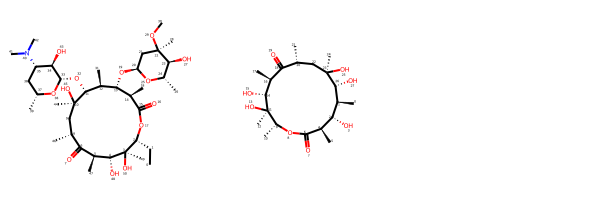

In [126]:
erythromycin = Chem.MolFromSmiles('CC[C@@H]1[C@@]([C@@H]([C@H](C(=O)[C@@H](C[C@@]([C@@H]([C@H]([C@@H]([C@H](C(=O)O1)C)O[C@H]2C[C@@]([C@H]([C@@H](O2)C)O)(C)OC)C)O[C@H]3[C@@H]([C@H](C[C@H](O3)C)N(C)C)O)(C)O)C)C)O)(C)O ')
erythromycin_fragment = Chem.MolFromSmiles(MolFragmentToSmiles(erythromycin, atomsToUse=get_max_ring_with_adjancent(erythromycin)))

Draw.MolsToGridImage([erythromycin, erythromycin_fragment])